In [1]:
import sys
sys.path.insert(0, "/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/")

import os,scipy,time
import numpy as np
import matplotlib.pyplot as plt

from acados_template import AcadosOcpSolver, AcadosOcp

from morphing_lander.mpc.dynamics import export_robot_model_phi
from morphing_lander.mpc.parameters import params_

In [2]:
# select number of collocation points and time horizon
N_horizon = 100
T_horizon = 5.0

# select cost function
Q_mat = np.diag([10,10,10,0.1,0.1,0.1,1,1,50,1.5,1.5,1.5,1.0])
R_mat = np.diag([0.1,0.1,0.1,0.1,0.1])
Q_mat_terminal = Q_mat

# constraints
u_max = params_.get('u_max')

# initialize variables (will be overwritten)
x_ref = np.zeros(13,dtype='float')
u_ref = np.zeros(5,dtype='float')
x0    = np.zeros(13,dtype='float')

def create_ocp_solver_description_phi() -> AcadosOcp:
    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    model = export_robot_model_phi()
    ocp.model = model
    nx = model.x.size()[0]
    nu = model.u.size()[0]
    ny = nx + nu

    # set dimensions
    ocp.dims.N = N_horizon

    ocp.cost.cost_type = "LINEAR_LS"
    ocp.cost.cost_type_e = "LINEAR_LS"

    ny = nx + nu
    ny_e = nx

    ocp.cost.W_e = Q_mat_terminal
    ocp.cost.W = scipy.linalg.block_diag(Q_mat, R_mat)

    ocp.cost.Vx = np.zeros((ny, nx))
    ocp.cost.Vx[:nx, :nx] = np.eye(nx)

    Vu = np.zeros((ny, nu))
    Vu[nx : nx + nu, 0:nu] = np.eye(nu)
    ocp.cost.Vu = Vu

    ocp.cost.Vx_e = np.eye(nx)

    ocp.cost.yref = np.hstack((x_ref,u_ref))
    ocp.cost.yref_e = x_ref

    # set input constraints
    ocp.constraints.lbu = np.array([0,0,0,0,0])
    ocp.constraints.ubu = np.array([+u_max,+u_max,+u_max,+u_max,1])
    ocp.constraints.idxbu = np.array([0,1,2,3,4])
    
    ocp.constraints.x0 = x0
    
    # set options
    ocp.solver_options.qp_solver       = "FULL_CONDENSING_HPIPM"       # FULL_CONDENSING_QPOASES
    ocp.solver_options.hessian_approx  = "GAUSS_NEWTON"                # 'GAUSS_NEWTON', 'EXACT'
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP_RTI"                     # SQP_RTI, SQP

    # set prediction horizon
    ocp.solver_options.tf = T_horizon

    return ocp

In [3]:

# desired reference and initial state
x_ref = np.array([0,0,0,0,0,0,0,0,0,0,0,0,np.pi/2])
u_ref = np.array([0,0,0,0,0])
x0    = np.array([0,0,-1.5,0,0,0,0,0,0,0,0,0,0])

# compile acados solver (ocp)
ocp        = create_ocp_solver_description_phi()

acados_ocp_solver = AcadosOcpSolver(
    ocp, 
    generate=True,
    build   =True
)

start_time = time.process_time()
# solver initialization
for stage in range(N_horizon + 1):
    acados_ocp_solver.set(stage, "x", np.zeros(13))

# run solver
acados_ocp_solver.set(0, "lbx", x0)
acados_ocp_solver.set(0, "ubx", x0)

# set the reference
for j in range(N_horizon):
    yref = np.hstack((x_ref,u_ref))
    acados_ocp_solver.set(j, "yref", yref)

# solve ocp1e-12
mpc_status = acados_ocp_solver.solve()  
print(f"mpc_status: {mpc_status}")

comp_time = time.process_time() - start_time
print("* comp time = %5g seconds\n" % (comp_time))

# get first input
x_vec, u_vec = [],[]
for j in range(N_horizon-1):
    u_vec.append(acados_ocp_solver.get(j, "u"))   
    x_vec.append(acados_ocp_solver.get(j, "x"))
x_vec.append(acados_ocp_solver.get(N_horizon, "x"))
x_vec = np.array(x_vec)
u_vec = np.array(u_vec)

rm -f libacados_ocp_solver_morphing_lander.so
rm -f acados_solver_morphing_lander.o
cc -fPIC -std=c99   -O2 -I/home/m4pc/src/acados/include -I/home/m4pc/src/acados/include/acados -I/home/m4pc/src/acados/include/blasfeo/include -I/home/m4pc/src/acados/include/hpipm/include  -c -o acados_solver_morphing_lander.o acados_solver_morphing_lander.c
cc -fPIC -std=c99   -O2 -I/home/m4pc/src/acados/include -I/home/m4pc/src/acados/include/acados -I/home/m4pc/src/acados/include/blasfeo/include -I/home/m4pc/src/acados/include/hpipm/include  -c -o morphing_lander_model/morphing_lander_expl_ode_fun.o morphing_lander_model/morphing_lander_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/m4pc/src/acados/include -I/home/m4pc/src/acados/include/acados -I/home/m4pc/src/acados/include/blasfeo/include -I/home/m4pc/src/acados/include/hpipm/include  -c -o morphing_lander_model/morphing_lander_expl_vde_forw.o morphing_lander_model/morphing_lander_expl_vde_forw.c
cc -fPIC -std=c99   -O2 -I/home/m4pc/src/acados/in

In [10]:
# save for future use 
t_vec = np.linspace(0, T_horizon, N_horizon) 
t_vec = t_vec[:-1]

np.save('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/morphing_lander/mpc/optimal_trajectory/x_vec.npy',     x_vec[:-1])
np.save('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/morphing_lander/mpc/optimal_trajectory/u_vec.npy',     u_vec)
np.save('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/morphing_lander/mpc/optimal_trajectory/t_vec.npy',     t_vec)
np.save('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/morphing_lander/mpc/optimal_trajectory/N_horizon.npy', N_horizon)
np.save('/home/m4pc/m4v2-code/m4_ws/src/morphing_lander/morphing_lander/mpc/optimal_trajectory/T_horizon.npy', T_horizon)


In [9]:
x_vec[:-1].shape

(99, 13)

<Figure size 1000x800 with 0 Axes>

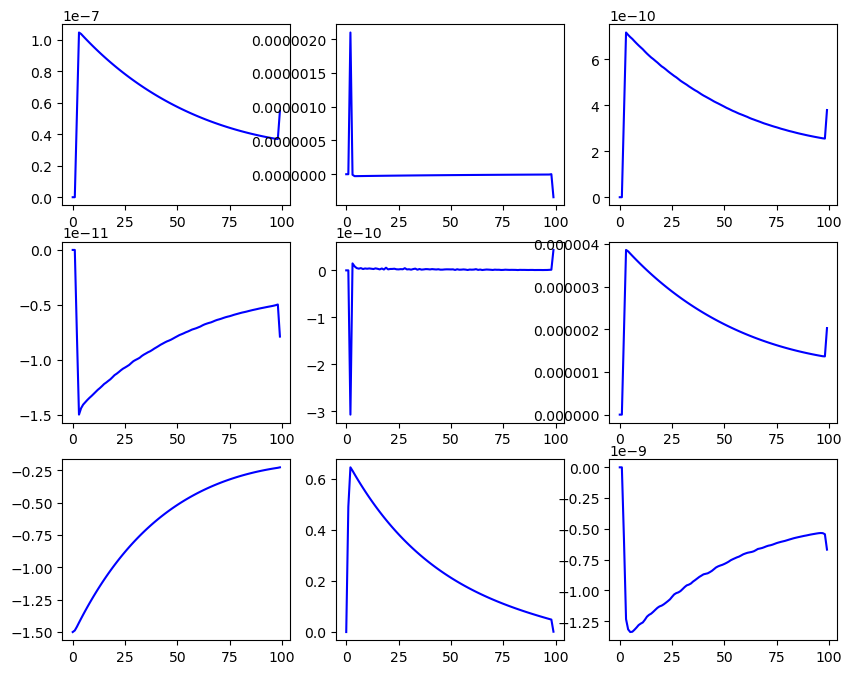

<Figure size 1000x800 with 0 Axes>

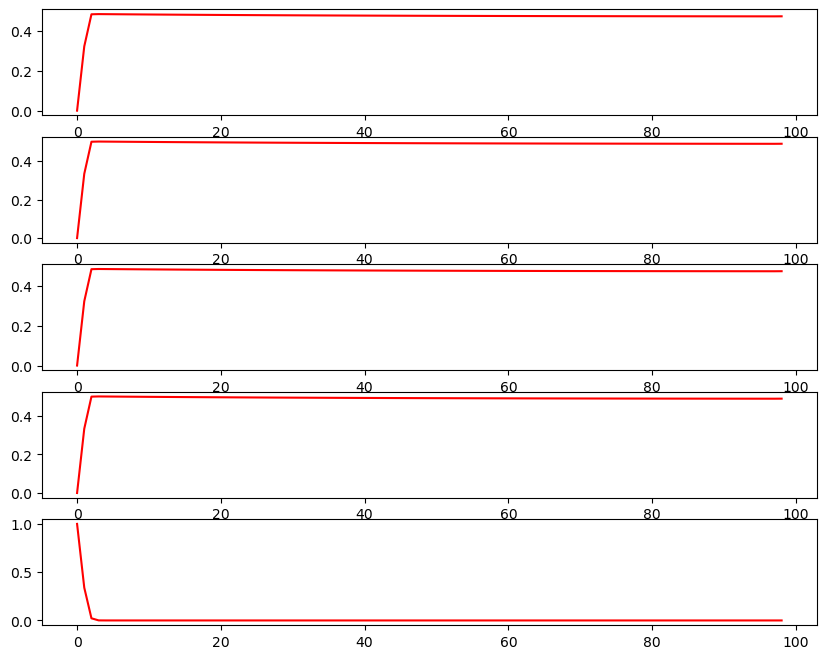

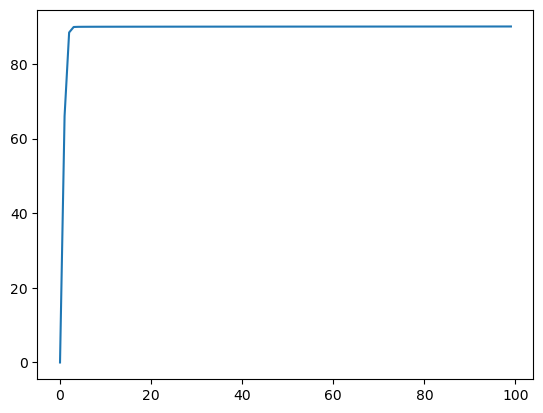

In [5]:
plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

# Plot states
axs[0, 0].plot(x_vec[:, 0], 'b')
axs[1, 0].plot(x_vec[:, 1], 'b')
axs[2, 0].plot(x_vec[:, 2], 'b')
axs[0, 1].plot(x_vec[:, 6], 'b')
axs[1, 1].plot(x_vec[:, 7], 'b')
axs[2, 1].plot(x_vec[:, 8], 'b')
axs[0, 2].plot(x_vec[:, 5], 'b')
axs[1, 2].plot(x_vec[:, 4], 'b')
axs[2, 2].plot(x_vec[:, 3], 'b')

plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(5, 1, figsize=(10, 8))
axs[0].plot(u_vec[:,0],'r')
axs[1].plot(u_vec[:,1],'r')
axs[2].plot(u_vec[:,2],'r')
axs[3].plot(u_vec[:,3],'r')
axs[4].plot(u_vec[:,4],'r')

plt.figure()
plt.plot(np.rad2deg(x_vec[:,-1]))

In [ ]:
x_vec = x_vec[:-1,:]

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def create_interpolators(t_vec, x_vec, u_vec):
    # Create interpolation functions for each column in x_vec and u_vec
    x_interpolators = [interp1d(t_vec, x_vec[:, i], kind='linear', fill_value='extrapolate') for i in range(x_vec.shape[1])]
    u_interpolators = [interp1d(t_vec, u_vec[:, i], kind='linear', fill_value='extrapolate') for i in range(u_vec.shape[1])]
    
    return x_interpolators, u_interpolators

def interpolate_values(x_interpolators, u_interpolators, t_new):
    # Interpolate values for the new time value
    x_new = np.array([interp(t_new) for interp in x_interpolators])
    u_new = np.array([interp(t_new) for interp in u_interpolators])
    
    return x_new, u_new

# Example usage:
# Create some example data
t_vec = np.linspace(0, T_horizon, N_horizon)  # Example time values from 0 to 10
t_vec = t_vec[:-1]

print(t_vec.shape)
print(x_vec.shape)
print(u_vec.shape)
# Create interpolators
x_interpolators, u_interpolators = create_interpolators(t_vec, x_vec, u_vec)

# Interpolate values for a new time value, for example 5.5
t_new = 5.5
start_time = time.process_time()
x_new, u_new = interpolate_values(x_interpolators, u_interpolators, t_new)
comp_time = time.process_time() - start_time
print("* comp time = %5g seconds\n" % (comp_time))

print("Interpolated x values at time", t_new, ":", x_new)
print("Interpolated u values at time", t_new, ":", u_new)
